In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.cluster import KMeans
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import random
import os
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from scipy.stats import norm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Load data and reshape it

## Split data into train, validation and test 

In [62]:

# S1=np.loadtxt('sparameters_1200.txt') 
# S1=S1[700:1200,:] # 500 samples

# S2=np.loadtxt('sparameters_2700.txt')
# S2=S2[100:300,:] # 200 samples
# #S11=np.concatenate((S1,S2),axis=0)

# S3=np.loadtxt('sparameters_2100.txt')
# S3=S3[0:300,:] # 300 samples
# #S11=np.concatenate((S1,S2,S3),axis=0)

# S4=np.loadtxt('sparameters_1800.txt')
# S4=S4[0:300,:] # 300 samples
# # S11=np.concatenate((S1,S2,S3,S4),axis=0)

# S5=np.loadtxt('sparameters_200.txt')
# S5=S5[0:200,:] # 200 samples

# S6=np.loadtxt('sparameters_1500.txt')
# S6=S6[0:300,:] # 300 samples

# x1=np.loadtxt("patchcoords_1200.txt",delimiter=',')

# x1 = x1[700*36:1200*36,:]
# x2=np.loadtxt('patchcoords_2700.txt',delimiter=',')

# x2 = x2[100*36:300*36,:]
# #xx=np.concatenate((x1,x2),axis=0)
# x3=np.loadtxt('patchcoords_2100.txt',delimiter=',')

# x3 = x3[0:300*36,:]
# #xx=np.concatenate((x1,x2,x3),axis=0)
# x4=np.loadtxt('patchcoords_1800.txt',delimiter=',')

# x4 = x4[0:300*36,:]
# # xx=np.concatenate((x1,x2,x3,x4),axis=0)
# x5=np.loadtxt('patchcoords_200.txt',delimiter=',')

# x5 = x5[0:200*36,:]
# x6=np.loadtxt('patchcoords_1500.txt',delimiter=',')

# x6 = x6[0:300*36,:]

# # xx=np.concatenate((x1,x2,x3,x4,x5,x6),axis=0)
# # S11=np.concatenate((S1,S2,S3,S4,S5,S6),axis=0)
xx = np.loadtxt('patchcoords_5.75_2800.txt', delimiter='\t')
xx =xx.reshape(2800*36,6)

xx = xx[0:2800*36, :]

S7 = np.loadtxt('sparameters_5.75_2800.txt')
S7 = S7[0:2800, :]
S11 = S7
print(xx.shape,S11.shape)
# # Get the maximum value in xx
# max_vals = np.max(xx)
# # Get the minimum value in xx
# min_vals = np.min(xx)
# print(f"Maximum value in xx: {max_vals}")
# print(f"Minimum value in xx: {min_vals}")

# # Normalize the data using min-max normalization
# # xx = (xx - min_vals) / (max_vals - min_vals)
# xx= xx.reshape(1800,216)

# Ensure xx is a PyTorch tensor; if it's a numpy array or other format, convert it
if not isinstance(xx, torch.Tensor):
    xx = torch.tensor(xx)

print("Original shape of xx:", xx.shape)

# Calculate the number of designs
num_designs = xx.shape[0] // 36  # should be 1800
print("Calculated number of designs:", num_designs)

# Reshape xx to separate each design with 36 patches, each having 6 parameters
# Shape will be (1800, 36, 6)
try:
    xx = xx.reshape(num_designs, 36, 6)
    print("Reshaped to designs:", xx.shape)
except RuntimeError as e:
    print("Error reshaping xx:", e)

# Now, further reshape each design into a 6x6 grid for each parameter
# This results in (1800, 6, 6, 6) where we consider 6x6 grid as spatial dimensions and 6 as channels
try:
    xx = xx.reshape(num_designs, 6, 6, 6)
    print("Reshaped for 2D CNN:", xx.shape)

    # To get channels in the correct order (N, C, H, W) for CNN input:
    # Current: (1800, 6, 6, 6) with (N, H, W, C)
    # Needed: (1800, 6, 6, 6) with (N, C, H, W)
    xx = xx.permute(0, 3, 1, 2)
    print("Final shape for CNN:", xx.shape)
except RuntimeError as e:
    print("Error in final reshaping or permuting:", e)


# Assuming S11 values are correctly loaded and formatted
S11_tensor = torch.tensor(S11, dtype=torch.float32)




print(xx.shape,S11_tensor.shape)

(100800, 6) (2800, 128)
Original shape of xx: torch.Size([100800, 6])
Calculated number of designs: 2800
Reshaped to designs: torch.Size([2800, 36, 6])
Reshaped for 2D CNN: torch.Size([2800, 6, 6, 6])
Final shape for CNN: torch.Size([2800, 6, 6, 6])
torch.Size([2800, 6, 6, 6]) torch.Size([2800, 128])


## Train model 

In [36]:
def train_model(model, train_loader, validation_loader, criterion, optimizer, num_epochs=1000):
    model = model.float()  # Ensure the model is in float mode
    train_losses=[]
    val_losses=[]
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels.view(-1, 1))  # Calculate loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Optimize the weights

            running_loss += loss.item() * inputs.size(0)
        

        train_losses.append(running_loss / len(train_loader))

        model.eval()  # Set the model to evaluation mode for validation
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in validation_loader:
                inputs, labels = inputs.float(), labels.float()  # Convert inputs and labels to float
                outputs = model(inputs)
                loss = criterion(outputs, labels.view(-1, 1))
                val_loss += loss.item()

        val_losses.append(val_loss / len(validation_loader))

        if (epoch+1)%100==0:
            print(f'Epoch {epoch + 1}/{num_epochs}, '
              f'Train Loss: {running_loss / len(train_loader):.4f}, '
              f'Validation Loss: {val_loss / len(validation_loader):.4f}')

    return train_losses, val_losses, model



## Evaluate the model

In [21]:
def evaluate_model(model, test_loader):
                  # Ensure your model is set to float
    model = model.float()
    model.eval()
    predictions, actuals = [], []
    
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.float(), targets.float()  
            outputs = model(data)
            predictions.append(outputs.cpu().numpy())  # Append batches
            actuals.append(targets.cpu().numpy())      # Append batches
    
    # Concatenate batches into single numpy arrays
    predictions = np.concatenate(predictions, axis=0)
    actuals = np.concatenate(actuals, axis=0)
    
    # Calculate metrics
    mse = mean_squared_error(actuals.ravel(), predictions.ravel())
    r2 = r2_score(actuals.ravel(), predictions.ravel())

    print(f'Mean Squared Error on test dataset: {mse}')
    #print(f'R-squared: {r2}')

## Define the 2D CNN model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN2D(nn.Module):
    def __init__(self):
        super(CNN2D, self).__init__()
        # Layer 1: Conv1 -> BatchNorm1 -> ReLU -> Dropout1
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.dropout1 = nn.Dropout(0.25)

        # Layer 2: Conv2 -> BatchNorm2 -> ReLU -> Dropout2
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.dropout2 = nn.Dropout(0.25)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 28 * 28, 128)  # Assuming input size of 28x28
        self.fc2 = nn.Linear(128, 10)  # Output layer with 10 units for classification

    def forward(self, x):
        # Apply first conv layer, then batch norm, ReLU, and dropout
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout1(x)

        # Apply second conv layer, then batch norm, ReLU, and dropout
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout2(x)

        # Flatten the output from Conv2 to feed into fully connected layers
        x = x.view(x.size(0), -1)

        # Apply first fully connected layer and ReLU activation
        x = self.fc1(x)
        x = F.relu(x)

        # Output layer
        x = self.fc2(x)
        return x


In [ ]:
class ComplexCNN1(nn.Module):
    def __init__(self):
        super(ComplexCNN1, self).__init__()
        self.conv1 = nn.Conv2d(6, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 3 * 3, 256)  # Adjusted based on pooling output
        self.fc2 = nn.Linear(256, 128)  # Output layer
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.3)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.dropout1(x)
        x = self.pool(x)  # Pooling after the first conv layer
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.dropout2(x)
        x = self.pool(x)  # Pooling after the second conv layer
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)  # Additional pooling layer
        x = x.view(-1, 128 * 3 * 3)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [ ]:
class ComplexCNN2(nn.Module):
    def __init__(self):
        super(ComplexCNN2, self).__init__()
        self.conv1 = nn.Conv2d(6, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = self.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = x.view(-1, 128 * 3 * 3)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


(4088, 16) (4088, 128)
Epoch 100/1000, Train Loss: 3.4259, Val Loss: 3.0200
Epoch 200/1000, Train Loss: 3.0752, Val Loss: 2.7446
Epoch 300/1000, Train Loss: 2.8018, Val Loss: 2.5517
Epoch 400/1000, Train Loss: 2.6354, Val Loss: 2.5075
Epoch 500/1000, Train Loss: 2.4762, Val Loss: 2.4265
Epoch 600/1000, Train Loss: 2.2997, Val Loss: 2.3629
Epoch 700/1000, Train Loss: 2.2902, Val Loss: 2.3400
Epoch 800/1000, Train Loss: 2.1878, Val Loss: 2.2679
Epoch 900/1000, Train Loss: 2.1448, Val Loss: 2.3036
Epoch 1000/1000, Train Loss: 2.0973, Val Loss: 2.2014


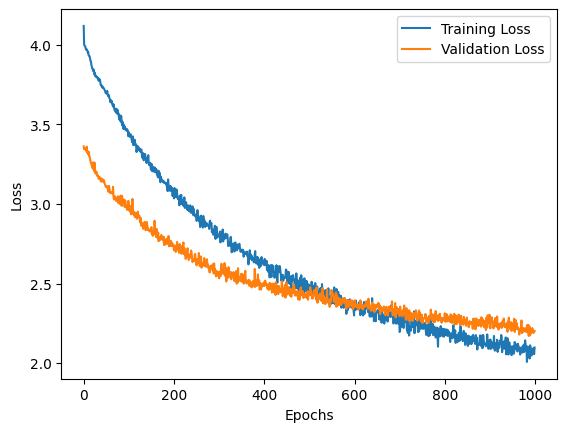

In [59]:
# Initialize the model
model = CNN2D()


# Loss and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.0025)

# Train and evaluate the model
train_losses, val_losses, model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=3000)


# Plotting losses
plot_loss(train_losses_full_dataset, val_losses_full_dataset)

(4088, 16) (4088, 128)
Epoch 100/200, Train Loss: 1.2672, Val Loss: 1.9344
Epoch 200/200, Train Loss: 0.9464, Val Loss: 1.8321


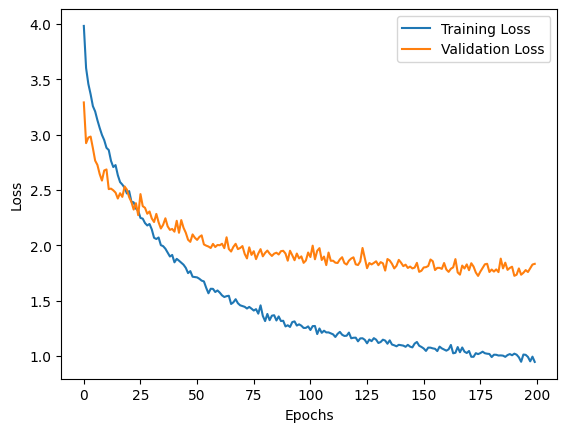

In [60]:
# Initialize the model
model = ComplexCNN1()


# Loss and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.0025)

# Train and evaluate the model
train_losses, val_losses, model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=3000)


# Plotting losses
plot_loss(train_losses_full_dataset, val_losses_full_dataset)

(4088, 16) (4088, 128)
X_train: torch.Size([2861, 16]) X_val: torch.Size([817, 16]) X_test: torch.Size([410, 16])
y_train: torch.Size([2861, 128]) y_val: torch.Size([817, 128]) y_test: torch.Size([410, 128])
Batch from training loader: torch.Size([32, 16]) torch.Size([32, 128])
Batch from validation loader: torch.Size([32, 16]) torch.Size([32, 128])
Batch from test loader: torch.Size([32, 16]) torch.Size([32, 128])
Epoch 100/1000, Train Loss: 1.2529, Val Loss: 1.9020
Epoch 200/1000, Train Loss: 0.9517, Val Loss: 1.7976
Epoch 300/1000, Train Loss: 0.8622, Val Loss: 1.6834
Epoch 400/1000, Train Loss: 0.8167, Val Loss: 1.7184
Epoch 500/1000, Train Loss: 0.7943, Val Loss: 1.9304
Epoch 600/1000, Train Loss: 0.7979, Val Loss: 1.7749
Epoch 700/1000, Train Loss: 0.7123, Val Loss: 1.7412
Epoch 800/1000, Train Loss: 0.6806, Val Loss: 1.8117
Epoch 900/1000, Train Loss: 0.6936, Val Loss: 1.7385
Epoch 1000/1000, Train Loss: 0.6390, Val Loss: 1.7990


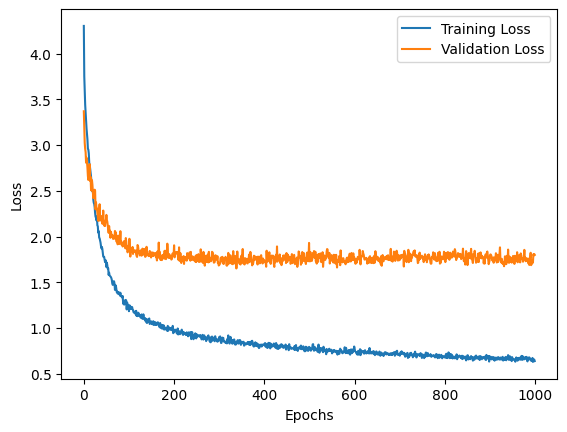

In [57]:
# Initialize the model
model = ComplexCNN2()


# Loss and optimizer
criterion = nn.MSELoss()  # Mean Squared Error Loss
optimizer = optim.Adam(model.parameters(), lr=0.0025)

# Train and evaluate the model
train_losses, val_losses, model = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=3000)


# Plotting losses
plot_loss(train_losses_full_dataset, val_losses_full_dataset)